#Face Mask Detection Model

In [1]:
%pip install kagglehub
%pip install pyyaml h5py

In [2]:
# นำเข้า modules ของ libraries
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.pyplot import figure
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from kagglehub import login, dataset_download
from pandas import DataFrame
from google.colab.patches import cv2_imshow
import multiprocessing
from functools import partial
from multiprocessing import Manager
from tqdm import tqdm
import pandas as pd
import random
from tensorflow.python.eager import profiler

In [3]:
# แสดง version ปัจจุบันที่กำลังใช้งาน tensorflow
print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
#บังคับใช้ GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


In [4]:
# Login เข้า Kaggle (ต้องดาวโหลด์ใบ credentail จาก kaggle ก่อนแล้วเอา username กับ key มากรอก)
# หรือถ้าไม่มีให้ใช้ข้อมูลด้านล่างต่อไปนี้

# ให้นำค่า value ไปกรอกในฟอร์มของ kaggle
kaggle_api = {
    "username":"warinsaipanya",
    "key":"e9d6ec16f057b50fac90908de9990b27"
}

login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [7]:
# ดาวโหลด์ตัว dataset จาก kaggle เก็บไว้ใน path ที่ระบุ
path = dataset_download("andrewmvd/face-mask-detection")
# แสดง path ที่เก็บ dataset
print(f"path ของไฟล์ dataset อยู่ที่: {path}")

path ของไฟล์ dataset อยู่ที่: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [8]:
# ตัวแปร classes เก็บเป็น  tuple ไว้เก็บคำตอบ
classes = ("mask_weared_incorrect", "with_mask", "without_mask")

In [44]:
# ชื่อ models ทั้งหมด
model_names = ("Neural Network", "KNN", "Desicion Tree", "Random Forest")

# สร้างตัวแปรเก็บเป็น list ไว้เก็บค่าตัวเลขผลลัพธ์ของ model เพื่อนำไป plot graph และ ทำตาราง
accuracy_values = []
precision_values = []
recall_values = []

# function สำหรับเพิ่มค่า element ให้ตัวแปร list ด้านบน
def add_elements(accuracy, precision, recall):
  accuracy_values.append(accuracy)
  precision_values.append(precision)
  recall_values.append(recall)

In [10]:
# path ที่เก็บข้อมูลรูปภาพไว้ train
folder_path = f"{path}/images"
# path ที่เก็บข้อมูลไฟล์ xml
xml_folder = f"{path}/annotations"

In [11]:
# function สำหรับการอ่านข้อมูลในไฟล์ xml
def parse_xml(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()
    # เก็บข้อมูลใน tag ของ object
    objects = []

    # หา tag filename แล้วอ่านข้อมูลด้านใน content
    filename = root.find("filename").text
    # หา tag size
    size = root.find("size")
    # อ่านค่า width และ height ใน element size
    width = size.find("width").text
    height = size.find("height").text

    # วน loop หา element ที่มีชื่อว่า object และได้กลับคืนมาเป็น list แล้ววน loop
    for obj in root.findall("object"):
        # หา tag ที่ชื่อ name แล้วอ่าน content ด้านในเก็บ class คำตอบของรูป
        label = obj.find("name").text
        # หา tag bndbox
        bndbox = obj.find("bndbox")
        # อ่านข้อมูลด้านใน element bndbox แล้วแปลงค่าเป็น int
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        # เพื่อ dictionary เข้าไปใน list
        objects.append({"filename": filename, "size": { "width": width, "height": height }, "label": label, "bndbox": [xmin, ymin, xmax, ymax]})

    return objects

In [12]:
# ฟังก์ชัน extract_number จะพยายามค้นหาตัวเลขภายในชื่อไฟล์ หากพบตัวเลข จะส่งคืนตัวเลขนั้นเป็นจำนวนเต็ม หากไม่พบตัวเลขใดๆ จะส่งคืน -1
def extract_number(filename):
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else -1

In [13]:
# list เก็บชื่อไฟล์ xml แบบเรียงลำดับชื่อไฟล์เป็นไฟล์ข้อมูลสำหรับแต่หล่ะรูปภาพ
xml_files = sorted(os.listdir(xml_folder), key=extract_number)
# สร้าง object ของ label encoder ไว้ normalize ตัว label ของรูป
encoder = LabelEncoder()

# แสดงผล list ที่เก็บไฟล์ xml ไว้
print(xml_files)

['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss2.xml', 'maksssksksss3.xml', 'maksssksksss4.xml', 'maksssksksss5.xml', 'maksssksksss6.xml', 'maksssksksss7.xml', 'maksssksksss8.xml', 'maksssksksss9.xml', 'maksssksksss10.xml', 'maksssksksss11.xml', 'maksssksksss12.xml', 'maksssksksss13.xml', 'maksssksksss14.xml', 'maksssksksss15.xml', 'maksssksksss16.xml', 'maksssksksss17.xml', 'maksssksksss18.xml', 'maksssksksss19.xml', 'maksssksksss20.xml', 'maksssksksss21.xml', 'maksssksksss22.xml', 'maksssksksss23.xml', 'maksssksksss24.xml', 'maksssksksss25.xml', 'maksssksksss26.xml', 'maksssksksss27.xml', 'maksssksksss28.xml', 'maksssksksss29.xml', 'maksssksksss30.xml', 'maksssksksss31.xml', 'maksssksksss32.xml', 'maksssksksss33.xml', 'maksssksksss34.xml', 'maksssksksss35.xml', 'maksssksksss36.xml', 'maksssksksss37.xml', 'maksssksksss38.xml', 'maksssksksss39.xml', 'maksssksksss40.xml', 'maksssksksss41.xml', 'maksssksksss42.xml', 'maksssksksss43.xml', 'maksssksksss44.xml', 'maksssksksss45.xml

### ตาราง

In [14]:
# สร้างตัวแปร list ไว้เก็บข้อมูลที่ได้จากการอ่านค่าข้อมูลจากไฟล์ .xml เพื่อนำข้อมูลไปทำเป็นตาราง dataframe
filenames = []
labels = []
widths = []
heights = []
xmins = []
ymins = []
xmaxes = []
ymaxes= []

# วน loop แต่ล่ะชื่อ xml file
for file in xml_files:

    # เอา path ของที่เก็บไฟล์ xml  มา join กับชื่อไฟล์ จะได้ตำแหน่ง path ที่แท้จริงของไฟล์ xml
    file_path = os.path.join(xml_folder, file)

    # เช็คตรวจสอบไฟล์ว่ามี path ไฟล์นั้นอยู่จริงไหม หรือไฟล์นั้นไม่ใช่ไฟล์ นามสกุล .xml ให้ข้าม loop นั้น
    if not os.path.isfile(file_path) or not file.lower().endswith('.xml'):
        continue

    # อ่านค่าข้อมูลไฟล์ .xml ได้เป็น list ของ dictionary หลายๆอัน
    objects = parse_xml(file_path)

    # loop ผ่าน objects ได้ค่า element ออกมาทีล่ะรอบ
    for object in objects:
      # เพิ่มค่า elements เข้าไปใน list
      filenames.append(object["filename"])
      labels.append(object["label"])
      widths.append(object["size"]["width"])
      heights.append(object["size"]["height"])
      xmins.append(object["bndbox"][0])
      ymins.append(object["bndbox"][1])
      xmaxes.append(object["bndbox"][2])
      ymaxes.append(object["bndbox"][3])

In [15]:
# เตรียมข้อมูลเป็น dictionary แล้วส่งค่าเข้าไปใน dataframe
data = {
    "filename": filenames,
    "label": labels,
    "width": widths,
    "height": heights,
    "xmin": xmins,
    "ymin": ymins,
    "xmax": xmaxes,
    "ymax": ymaxes
}

# สร้าง object ของ dataframe แล้วส่งค่า argument ในการกำหนด index ให้แต่ล่ะแถว
df = DataFrame(data,index=[i for i in range(len(filenames))])

# แสดงข้อมูลและรายละเอียดตาราง
print(df.head())
print(df.info())
df.describe()

            filename         label width height  xmin  ymin  xmax  ymax
0  maksssksksss0.png  without_mask   512    366    79   105   109   142
1  maksssksksss0.png     with_mask   512    366   185   100   226   144
2  maksssksksss0.png  without_mask   512    366   325    90   360   141
3  maksssksksss1.png     with_mask   400    156   321    34   354    69
4  maksssksksss1.png     with_mask   400    156   224    38   261    73
<class 'pandas.core.frame.DataFrame'>
Index: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   width     4072 non-null   object
 3   height    4072 non-null   object
 4   xmin      4072 non-null   int64 
 5   ymin      4072 non-null   int64 
 6   xmax      4072 non-null   int64 
 7   ymax      4072 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 286.3+ KB
None


,xmin,ymin,xmax,ymax
count,4072.000000,4072.000000,4072.000000,4072.000000
mean,182.207024,85.780697,213.356090,120.785609
std,104.471254,52.571821,102.712267,70.355098
min,1.000000,1.000000,8.000000,6.000000
25%,96.000000,49.000000,134.000000,73.000000
50%,177.000000,75.000000,212.000000,103.000000
75%,266.000000,113.000000,292.000000,148.000000
max,569.000000,330.000000,592.000000,495.000000


In [16]:
# แสดงจำนวนคำตอบของ class ทั้งหมด
# ข้อมูล dataset ทั้งหมด 4072 จำนวน
# คนใส่แมสแบ่งเป็น 3232 คน
# คนไม่ใส่แมสแบ่งเป็น 717 คน
# คนใส่แมสไม่ถูกต้องแบ่งเป็น 123 คน
for label in classes:
  print(f'{label} = {len(df[df["label"] == label])}' )

mask_weared_incorrect = 123
with_mask = 3232
without_mask = 717


/usr/local/lib/python3.11/dist-packages/matplotlib/table.py:820: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


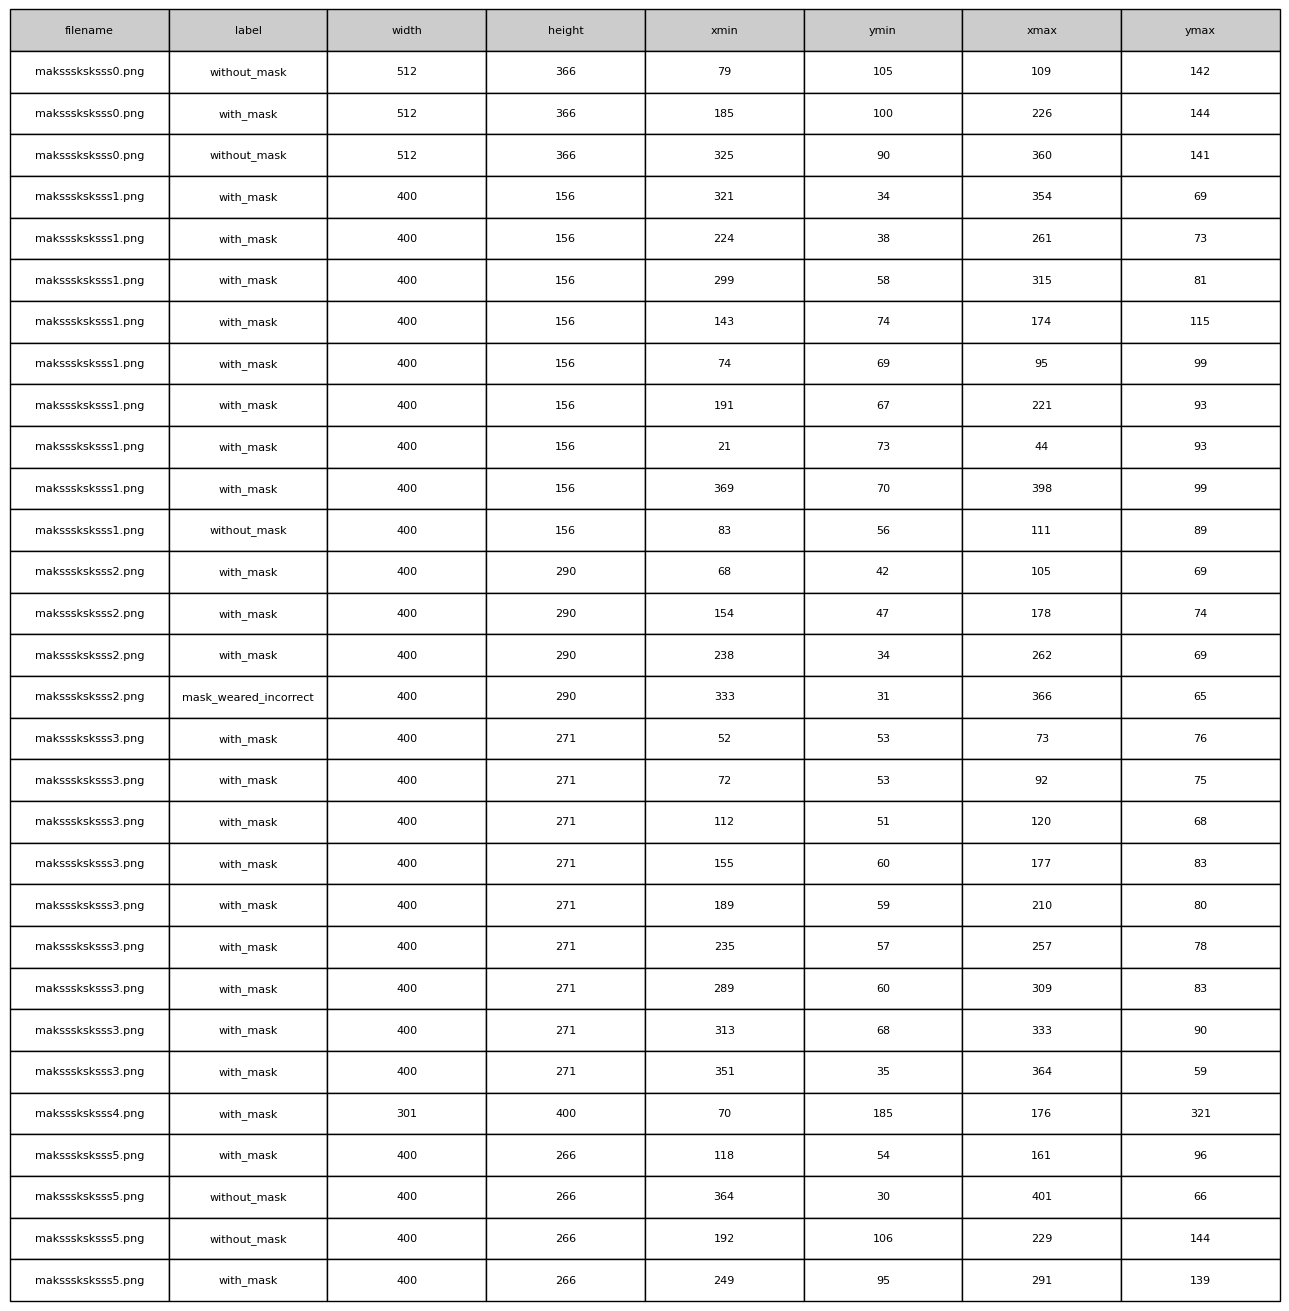

In [17]:
# กำหนดจำนวนแถวที่จะนำไปแสดงในตาราง
n = 30
# สร้าง list เพื่อเก็บ cells ในแต่ล่ะแถว
cell_texts = []

# วน loop ตามจำนวนรอบที่กำหนด
for i in range(n):
    # เพิ่มค่า cell ของแต่ล่ะแถว
    cell_texts.append(df.iloc[i])

# plot สร้าง table เป็นรูปภาพ
table = plt.table(cellText=cell_texts,
                  colLabels=df.columns,
                  colWidths=[0.4 for i in range(n)],
                  loc='center',
                  colColours=['0.8' for j in range(n)],
                  cellLoc='center'
              )
# ปรับขนาดของตารางในแนวแกน x และ y
table.scale(0.8, 2.5)

# ปิดใช้แกนของกราฟ
plt.axis('off')
# แสดงกราฟ
plt.show()

/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss0.png


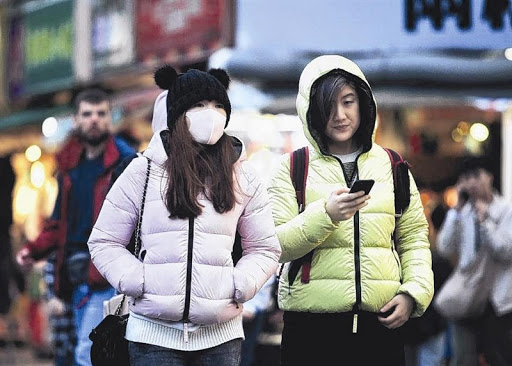

In [18]:
# list สำหรับเก็บ path ของไฟล์ xml และ รูปภาพ
image_paths = []
xml_paths = []

# วน loop รับ element แต่ล่ะไฟล์
for xml_file in xml_files:
  # แทนชื่อไฟล์นามสกุล .xml เป็น .png
  image_file = xml_file.replace(".xml", ".png")
  # เอา path folder ที่เก็บรูปภาพ มา join กับชื่อไฟล์รูปภาพ
  image_path = os.path.join(folder_path, image_file)
  # เพิ่ม element ของ path รูปภาพ
  image_paths.append(image_path)

  # path ไฟล์ xml มา join กับไฟล์ xml
  xml_path = os.path.join(xml_folder, xml_file)
  # เพิ่ม element ของ path xml
  xml_paths.append(xml_path)

# แสดงรายการรูปภาพใน list อันแรก
print(image_paths[0])

# อ่านรูปภาพไฟล์อันแรก
img = cv2.imread(image_paths[0], cv2.IMREAD_UNCHANGED)
# แสดงรูปภาพ
cv2_imshow(img)

In [19]:
# กำหนดค่า max ของ classes
# max_mask_weared_incorrect = 120
max_with_mask = 700
max_without_mask = 700

# สร้าง list รวมข้อมูลของภาพแต่ล่ะ class
x_with_masks = []
x_without_masks = []
x_mask_weared_incorrects = []

In [21]:
# สร้าง list รวมชื่อไฟล์ของคนใส่ mask
with_mask = df.loc[df['label'] == 'with_mask','filename'].to_list()
# สุ่มข้อมูล elements ทั้บหมดใน list
random.shuffle(with_mask)
# แสดงผล
print(f"with_mask data: {with_mask}")

# สร้าง list รวมชื่อไฟล์ของคนไม่ใส่ mask
without_mask = df.loc[df['label'] == 'without_mask','filename'].to_list()
# สุ่มข้อมูล elements ทั้บหมดใน list
random.shuffle(without_mask)
# สุ่มข้อมูล elements ทั้บหมดใน list
print(f"without_mask data: {without_mask}")

# wrong_mask = df.loc[df['label'] == 'mask_weared_incorrect','filename'].to_list()
# random.shuffle(with_mask)
# print(f"wrong_mask data: {wrong_mask}")

# datasets_index_with_cutting = with_mask[:max_with_mask] + without_mask[:max_without_mask]
# datasets_index_with_cutting = with_mask[:] + without_mask[:]+ wrong_mask[:]

# รวมไฟล์ทั้งหมดของคนใส่ mask และ ไม่ใส่ mask
datasets_index_with_cutting = with_mask[:] + without_mask[:]

# ใช้ set เพื่อไม่เอาชื่อไฟล์ที่ซ้ำกันและแปลงกับ list เหมือนเดิม
datasets_index_with_cutting = list(set(datasets_index_with_cutting))
print(f"datasets_index_with_cutting: {datasets_index_with_cutting}")

# ปริ้นจำนวนใน list ออกมา
print(f"\nmask index : {len(with_mask)}")
print(f"withoutmask index : {len(without_mask)}")
print(f"cutting index : {len(datasets_index_with_cutting)}")

with_mask data: ['maksssksksss558.png', 'maksssksksss301.png', 'maksssksksss74.png', 'maksssksksss221.png', 'maksssksksss61.png', 'maksssksksss787.png', 'maksssksksss93.png', 'maksssksksss75.png', 'maksssksksss807.png', 'maksssksksss752.png', 'maksssksksss752.png', 'maksssksksss378.png', 'maksssksksss603.png', 'maksssksksss820.png', 'maksssksksss39.png', 'maksssksksss49.png', 'maksssksksss826.png', 'maksssksksss247.png', 'maksssksksss385.png', 'maksssksksss294.png', 'maksssksksss705.png', 'maksssksksss486.png', 'maksssksksss776.png', 'maksssksksss768.png', 'maksssksksss774.png', 'maksssksksss535.png', 'maksssksksss706.png', 'maksssksksss718.png', 'maksssksksss836.png', 'maksssksksss341.png', 'maksssksksss780.png', 'maksssksksss676.png', 'maksssksksss58.png', 'maksssksksss257.png', 'maksssksksss573.png', 'maksssksksss312.png', 'maksssksksss158.png', 'maksssksksss222.png', 'maksssksksss36.png', 'maksssksksss539.png', 'maksssksksss758.png', 'maksssksksss559.png', 'maksssksksss358.png', 'm

In [22]:
# กำหนดตำเเหน่งของไฟล์สุดท้าย
file_index = -1
# กำหนดจำนวนเปอร์เซ็นที่ train
train_percent = 0.8
# กำหนดขนาด batch
batch_size = 256
# กำหนดจำนวนรอบ
epochs = 50

def fetch_dataset(file_name, shared_x, shared_y):
    #รับ index จาก index_file
    # i = index_file
    #หาไฟล์จากindex
    # file = xml_files[i]

    # แปลงชื่อไฟล์นามสกุล .png เป็น .xml
    file_name = file_name.replace (".png",".xml")
    # เก็บค่าลงตัวแปร file
    file = file_name
    # เอา path ของที่เก็บไฟล์ xml  มา join กับชื่อไฟล์ จะได้ตำแหน่ง path ที่แท้จริงของไฟล์ xml
    file_path = os.path.join(xml_folder, file)

    # เช็คตรวจสอบไฟล์ว่ามี path ไฟล์นั้นอยู่จริงไหม หรือไฟล์นั้นไม่ใช่ไฟล์ นามสกุล .xml ให้ข้าม loop นั้น
    if not os.path.isfile(file_path) or not file.lower().endswith('.xml'):
        return
    try:
        # แปลงไฟล์ นามสกุลลงท้าย .xml เป็น .png ชื่อไฟล์ xml กับ ชื่อรูปภาพเหมือนกันต่างกันแค่คนหล่ะนามสกุลไฟล์
        image_name = file.replace(".xml", ".png")
        # เอา path ที่เก็บรูปภาพมา join กับ ชื่อไฟล์รูปภาพที่พึ่งแก้นามสกุลไฟลืไป ได้เป็น path ของรูปภาพที่แท้จริง
        image_path = os.path.join(folder_path, image_name)

        # เช็คเงื่อนไขถ้า path ของรูปภาพไม่มีอยู่ ให้return
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        #อ่านรายละเอียดไฟล์xml
        objects = parse_xml(file_path)

        #ลูปหาlabel
        for _object in objects:
          #รับค่าlabel
          label = _object["label"]

          # tqdm.write(f"Processing {label}")
          # เช็คเงื่อนไขคำตอบว่าเป็นคนใส่ mask ไหม ถ้าเป็นจริงให้เพิ่มค่าเข้าไปใน list
          if label == "with_mask":
            x_with_masks.append(_object)

          # เช็คเงื่อนไขคำตอบว่าเป็นคนไม่ใส่ mask ไหม ถ้าเป็นจริงให้เพิ่มค่าเข้าไปใน list
          elif label == "without_mask":
            x_without_masks.append(_object)

          # เช็คเงื่อนไขคำตอบว่าเป็นคนใส่ mask ไม่ถูกต้องไหม ถ้าเป็นจริงให้เพิ่มค่าเข้าไปใน list
          elif label == "mask_weared_incorrect":
            x_mask_weared_incorrects.append(_object)

          # เปิดรูปภาพตามตำแหน่งของ path รูปภาพ
          img = cv2.imread(image_path)

          # position จาก xml
          xmins = _object['bndbox'][0]
          ymins = _object['bndbox'][1]
          xmaxes = _object['bndbox'][2]
          ymaxes = _object['bndbox'][3]

          #ตัดภาพเฉพาะส่วนหน้า
          img = img[ymins:ymaxes, xmins:xmaxes]

          # ปรับขนาดของรูปภาพที่ size หลายขนาดให้เป็นขนาด 128 x 128 (height = width)
          img = cv2.resize(img, (128,128))

          # แสดงรูปภาพออกมา
          # cv2_imshow(img)

          # เพิ่ม element เข้าไปใน list โดยให้รูปภาพปรับขนาดรูปร่างความกว้างและความสูงเป็น 128 และ มีช่องสีแค่ 3
          reshaped_array = np.array(img).reshape(128,128,3)

          #เเปลงarrayสำหรับเเสดงภาพ
          # converted_array = Image.fromarray(reshaped_array)
          # converted_array.show()

          # ให้ตัวแปร shared_y เก็บ class ของคำตอบแต่ล่ะรูป
          shared_y.append(objects[0]["label"])
          # ให้ตัวแปร shared_x เก็บ array รูป
          shared_x.append(reshaped_array)

    except Exception as e:
           print(f"Error processing {file}: {e}")

    else:
        #  print(f"Warning: No objects found in {file_path}")
         return

#ทำ multiprocessing
with Manager() as manager:
      # เก็บค่า shared_x เป็น list
      shared_x = manager.list()
      # เก็บค่า shared_y เป็น list
      shared_y = manager.list()

      #จำนวนรอบลูป จากไฟล์เเรกไปไฟล์สุดท้าย
      tasks = range(len(xml_files[:file_index]))

      #จำนวนรอบลูปตาม index ของ ไฟล์ ที่คัดกรอง
      filess_index = datasets_index_with_cutting

      # สร้าง object ของ multiprocess ชื่อ pool
      with multiprocessing.Pool(processes=min(multiprocessing.cpu_count(), len(xml_files))) as pool:
          #ทำ load_bar ชื่อ pbar
          with tqdm(total=len(filess_index),mininterval=0.1) as pbar:
              #ลูปเรียก function fetch_dataset รับค่า shared_x,shared_y,tasks
              for _ in pool.imap_unordered(partial(fetch_dataset, shared_x=shared_x, shared_y=shared_y), filess_index):
                  #update load_bar
                  pbar.update(1)
      #เเปลง x,y เป็น numpy array
      x = np.array(shared_x).astype("float32")
      y = np.array(shared_y)

      # encoded ตัวคำตอบ labels แปลงจาก string -> int ค่าอยู่ในช่วง 0 - 2
      y = encoder.fit_transform(y)

# เช็คถ้าข้อมูลนั้นไม่มีอยู่ให้โยน exception นี้ออกไป
if len(x) == 0 or len(y) == 0:
      raise ValueError("No data found! Check your dataset paths and XML annotations.")

#ทำ x,y ใน tensorDataset
datasets = tf.data.Dataset.from_tensor_slices((x, y))

#ไซส์ ของ datasets
datasets_size = len(datasets)

#กำหนดจำนวนรูปที่ใช้train
data_train_size = np.floor(train_percent*datasets_size)

# #show sample
# for imgarray,label in datasets.take(3):
#   cv2_imshow(np.array(imgarray))
#   print(classes[label])

#สลับข้อมูล
datasets = datasets.shuffle(datasets_size, reshuffle_each_iteration=False)
# train ได้ batch ตามจำนวน batch_size ตาม data_train_size
train_dataset = datasets.take(data_train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# test ได้ batch ตามจำนวน batch_size ตาม data_train_size ที่เหลืออยู่
test_dataset = datasets.skip(data_train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"batched train size:{len(train_dataset)}")
print(f"batched test size:{len(test_dataset)}")

# แปลงข้อมูล train dataset เป็น numpy iterator และแยกข้อมูล features (x_train) และ labels (y_train) ด้วย zip
x_train, y_train = zip(*train_dataset.unbatch())
# แปลงข้อมูล test dataset เป็น numpy iterator และแยกข้อมูล features (x_test) และ labels (y_test) ด้วย zip
x_test, y_test = zip(*test_dataset.unbatch().as_numpy_iterator())

# # แปลงข้อมูล train  x และ y เป็น array ของ numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# แปลงข้อมูล test  x และ y เป็น array ของ numpy
x_test = np.array(x_test)
y_test = np.array(y_test)

# ปริ้นแสดงข้อมูลรูปร่าง train และ test  โดย tuple มี 4 elements เก็บค่า จำนวนรูปคนที่ crop ออกมา, กว้าง, สูง และ ช่องสี 3 สี
# ส่วน y เก็บ tuple 1 element คือคำตอบของรูปภาพ
print(f"train shape (x,y):{x_train.shape},{y_train.shape}")
print(f"test shape (x,y):{x_test.shape},{y_test.shape}")

100%|██████████| 832/832 [00:58<00:00, 14.12it/s]


batched train size:13
batched test size:4
train shape (x,y):(3240, 128, 128, 3),(3240,)
test shape (x,y):(811, 128, 128, 3),(811,)


### Neural Netwoerk Model

In [23]:
# เก็บชื่อ folder
save_folder = "save"
# เก็บ path ของ neural network model
save_path = "save/model.keras"

# เช็คว่าถ้าไม่มี path ที่เก็บ model ให้สร้าง folder save ไว้ทำการเก็บ model
if not (os.path.exists(save_folder)):
  os.mkdir("save")

In [24]:
# สร้าง object ของ model
model = Sequential()

# เพิ่มแต่ล่ะ layers ให้ model
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Another convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Another convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Another convolutional block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Reduce dimensions
model.add(GlobalAveragePooling2D())

# model.add(Flatten(input_shape=(512, 512, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# แสดงรายการ folder save ว่ามี model ที่ save อยู่ไหม
print(os.listdir(save_folder))
print()

# set สถานะว่ากำลังรันอยู่
run_training = True

# เช็คถ้า save ยังเป็น list ว่าง (ยังไม่สร้างตัว model เสร็จ) หรือ อยู่ในสถานะรัน ให้ทำการ train model
if (os.listdir(save_folder) == [] or run_training):
  # train model 14 รอบ
  model.fit(train_dataset,epochs=epochs)
  # train เสร็จ save model ลง folder save
  model.save('save/model.keras')
  # กำหนดค่าให้เป็นเท็จ ปิดสถานะการ train
  run_training = False
else:
  # ได้ชื่อไฟล์ตัว model
  lastest = os.listdir(save_folder)
  # แสดงชื่อไฟล์ model
  print(f"using: {lastest}")
  #โหลด model ที่ save/model.keras
  model = tf.keras.models.load_model("save/model.keras")

# สรุปผลของตัว model
model.summary()

[]

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 984ms/step - accuracy: 0.7149 - loss: 0.7920
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.8137 - loss: 0.5445
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8192 - loss: 0.5038
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8270 - loss: 0.4989
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8332 - loss: 0.4753
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8323 - loss: 0.4772
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8297 - loss: 0.4691
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8379 - loss: 0.4509
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.8414 - loss: 0.4457
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8419 - loss: 0.4449
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8423 - loss: 0.4399
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,356,427 (8.99 MB)

 Trainable params: 785,155 (3.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,570,312 (5.99 MB)

In [29]:
# คำนวณค่า accuracy และ ค่า loss ของ model
loss, accuracy = model.evaluate(test_dataset)

# แสดงผลลัพธ์ค่า accuracy กับ loss ออกมา
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8159 - loss: 0.7332
Accuracy: 0.8187422752380371
Loss: 0.7190932035446167


In [30]:
# ทำนายค่าผลลัพธ์
y_pred = np.argmax(model.predict(x_test), axis=-1)

# คำนวณค่า precision และ recall
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# แสดงผลลัพธ์ precison กับ recall
print(f"Precision: {precision}")
print(f"Recall: {recall}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Precision: 0.7882048614440574
Recall: 0.8187422934648582


In [45]:
# เรียกใช้ function เพิ่มค่าที่สำคัญเข้าไปใน list
add_elements(accuracy, precision, recall)

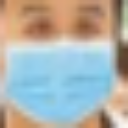

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Answer: with_mask
Predict: with_mask
Confidence: 0.998022198677063


In [33]:
# ตำเเหน่งรูปที่ใช้
img_index = 52

# รูปตัวอย่าง
img_array = x_test[img_index]
answer = y_test[img_index]
cv2_imshow(x_test[img_index])

# เพิ่ม dim ให้ model
img_array = np.expand_dims(img_array, axis=0)

# เเสดงรูป
# img_array.show()

# ความเเม่นยำ เเละ ความมั่นใจ
prediction = model.predict(img_array)[0]
predicted_class = np.argmax(prediction)
confidence = prediction[predicted_class]

# ปริ้นคำตอบจริงออกมา และเทียบดูกับค่า การทำนายของ model และค่าความมั่นใจของ model
print(f"Answer: {classes[answer]}")
print(f"Predict: {classes[predicted_class]}")
print(f"Confidence: {confidence}")

In [40]:
# แสดงจำนวนมิติของ train และ test
print(x_train.ndim)
print(x_test.ndim)
print(y_train.ndim)
print(y_test.ndim)

print()
# แสดงรูปร่างของข้อมูล train และ test
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

4
4
1
1

(3240, 128, 128, 3)
(811, 128, 128, 3)
(3240,)
(811,)


In [41]:
# แปลงจาก array 4 มิติให้เป็น array 2 มิติ
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)

# แปลงเป็๋น array 1 มิติ
y_train2 = y_train.reshape(y_train.shape[0], -1)
y_test2 = y_test.reshape(y_test.shape[0], -1)

# แสดงรูปร่างของข้อมูล train และ test
print(f"train_flat shape (x,y): {x_train2.shape}, {y_train2.shape}")
print(f"test_flat shape (x,y): {x_test2.shape}, {y_test2.shape}")

train_flat shape (x,y): (3240, 49152), (3240, 1)
test_flat shape (x,y): (811, 49152), (811, 1)


In [42]:
# แสดงรูปร่างของข้อมูล train และ test
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(3240, 49152)
(811, 49152)
(3240, 1)
(811, 1)


### KNN Model

In [46]:
# กำหนดโมเดล KNN
knn = KNeighborsClassifier(n_neighbors=15)

# ฝึกโมเดล KNN
knn.fit(x_train2, y_train2)

# ทำนายผลลัพธ์ในชุดทดสอบ
y_pred_knn = knn.predict(x_test2)

# คำนวณความแม่นยำของโมเดล KNN
accuracy_knn = accuracy_score(y_test2, y_pred_knn)

# คำนวณ  loss สำหรับ KNN โดยใช้ค่าความน่าจะเป็นจากการทำนาย
y_pred_prob = knn.predict_proba(x_test2)

# เเปลง labels เป็น one-hot
lb = LabelBinarizer()
y_test2_one_hot = lb.fit_transform(y_test2)

# กำหนดคลาสที่ต้องการใช้ในการคำนวณ  loss
KNN_loss = log_loss(y_test2_one_hot, y_pred_prob)

# คำนวณ precision และ recall ของ KNN
precision_knn = precision_score(y_test2, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test2, y_pred_knn, average='weighted')

# เพิ่มค่าผลลัพธ์ของ KNN เข้าไปใน list สำหรับเปรียบเทียบ
add_elements(accuracy_knn, precision_knn, recall_knn)

# แสดงผลความแม่นยำของ KNN ,  precision , recall และ loss
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN Recall: {recall_knn:.4f}")
print(f"KNN Loss: {KNN_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Accuracy: 0.8286
KNN Precision: 0.7744
KNN Recall: 0.8286
KNN Loss: 1.5352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


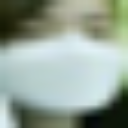

Answer: with_mask
Predict: with_mask
Confidence: 0.9333333333333333


In [48]:
# ตำเเหน่งรูปที่ใช้
img_index = 128

# รูปตัวอย่าง
img_array = x_test2[img_index]
answer = y_test[img_index]

# เพิ่ม dim ให้ model
img_array = np.expand_dims(img_array, axis=0)

# เเสดงรูป
cv2_imshow(x_test[img_index])

# ความเเม่นยำ เเละ ความมั่นใจ
predicted_class = knn.predict(img_array)[0]
y_pred_prob = knn.predict_proba(img_array)
confidence = y_pred_prob[0][predicted_class]

# ปริ้นค่าออกมาเทียบดูคำตอบจริง กับ คำตอบที่ model ทำนายออกมา
print(f"Answer: {classes[answer]}")
print(f"Predict: {classes[predicted_class]}")
print(f"Confidence: {confidence}")

### Desicion Tree Model

In [49]:
# สร้าง Decision Tree Model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# ฝึก Decision Tree Model
decision_tree_model.fit(x_train2, y_train2)

# ทำนายค่าผลลัพธ์จากข้อมูลทดสอบ
dt_y_pred = decision_tree_model.predict(x_test2)

# ทำนายค่าความน่าจะเป็นจาก Decision Tree Model
dt_y_prob = decision_tree_model.predict_proba(x_test2)

# คำนวณ Log Loss
dt_loss = log_loss(y_test2, dt_y_prob, labels=[0, 1, 2])

# คำนวณ Precision, Recall สำหรับ Decision Tree
dt_precision = precision_score(y_test2, dt_y_pred, average='weighted')
dt_recall = recall_score(y_test2, dt_y_pred, average='weighted')

# คำนวณ Accuracy
dt_accuracy = decision_tree_model.score(x_test2, y_test2)

# แสดงผลลัพธ์ของ Decision Tree Model
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Decision Tree Precision: {dt_precision}")
print(f"Decision Tree Recall: {dt_recall}")
print(f"Decision Tree Loss: {dt_loss}")

# เพิ่มผลลัพธ์ของ Decision Tree ลงใน list
add_elements(dt_accuracy, dt_precision, dt_recall)

Decision Tree Accuracy: 0.717632552404439
Decision Tree Precision: 0.7400962858881593
Decision Tree Recall: 0.717632552404439
Decision Tree Loss: 10.177554409504104


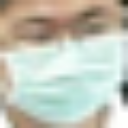

Answer: with_mask
Predict: with_mask
Confidence: 1.0


In [50]:
# ตำเเหน่งรูปที่ใช้
img_index = 70
img_array = x_test2[img_index]
answer = y_test[img_index]

# เพิ่ม dim ให้ model
img_array = np.expand_dims(img_array, axis=0)

# เเสดงรูป
cv2_imshow(x_test[img_index])

# ความเเม่นยำ เเละ ความมั่นใจ
predicted_class = decision_tree_model.predict(img_array)[0]
y_pred_prob = decision_tree_model.predict_proba(img_array)
confidence = y_pred_prob[0][predicted_class]

# ปริ้นค่าออกมาเทียบดูคำตอบจริง กับ คำตอบที่ model ทำนายออกมา
print(f"Answer: {classes[answer]}")
print(f"Predict: {classes[predicted_class]}")
print(f"Confidence: {confidence}")

### Random Forest Model

In [51]:
# สร้าง model random forest
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

# train model
rfc_model.fit(x_test2,y_test2)

# คำนวณค่า precision และ ค่า recall
rfc_precision_score = precision_score(y_test2, rfc_model.predict(x_test2),average="weighted")
rfc_recall_score = recall_score(y_test2, rfc_model.predict(x_test2),average="weighted")

# คำนวณค่า accuracy
rfc_test_acc = accuracy_score(y_test2, rfc_model.predict(x_test2))

# loss
rfc_loss = log_loss(y_train2,rfc_model.predict_proba(x_train2))

# แสดงผลลัพธ์
print("RFC Test Accuracy:", rfc_test_acc)
print("RFC Loss:", rfc_loss)
print("RFC Precision Score:", rfc_precision_score)
print("RFC Recall Score:", rfc_recall_score)

# เพิ่มค่าผลลัพธ์เข้าไปใน list
add_elements(rfc_test_acc, rfc_precision_score, rfc_recall_score)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RFC Test Accuracy: 1.0
RFC Loss: 0.6308431885524487
RFC Precision Score: 1.0
RFC Recall Score: 1.0


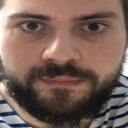

Answer: without_mask
Predict: without_mask
Confidence: 0.85


In [52]:
#ตำเเหน่งรูปที่ใช้
img_index = 104
img_array = x_test2[img_index]
answer = y_test[img_index]
cv2_imshow(x_test[img_index])

#เพิ่ม dim ให้ model
img_array = np.expand_dims(img_array, axis=0)

#ความเเม่นยำ เเละ ความมั่นใจ
predicted_class = rfc_model.predict(img_array)[0]
y_pred_prob = rfc_model.predict_proba(img_array)
confidence = y_pred_prob[0][predicted_class]

# ปริ้นค่าออกมาเทียบดูคำตอบจริง กับ คำตอบที่ model ทำนายออกมา
print(f"Answer: {classes[answer]}")
print(f"Predict: {classes[predicted_class]}")
print(f"Confidence: {confidence}")

In [53]:
# ปริ้นค่าผลลัพธ์ที่เก็บมา
print(accuracy_values)
print(precision_values)
print(recall_values)

[0.8187422752380371, 0.8286066584463625, 0.717632552404439, 1.0]
[0.7882048614440574, 0.7744473060281555, 0.7400962858881593, 1.0]
[0.8187422934648582, 0.8286066584463625, 0.717632552404439, 1.0]


### Plot graphs

In [57]:
# กำหนดค่าสีแต่ละ model ในกราฟแท่ง
bar_colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
# สร้าง list ไว้กำหนดป้ายแต่ล่ะป้ายที่จะแสดงในแกน y
acc_labels = []
pre_labels = []
rec_labels = []

In [58]:
# สร้าาง function สำหรับ plot graph
def plot_graph(title, y_label, y_labels, x_label = 'Models'):

  # ปรับขนาดของกราฟ
  figure(figsize=(10, 5.5))

  # แสดงกราฟตามค่า arguments ที่ส่งมา
  plt.bar(y_labels, accuracy_values, width=.5, label=model_names, color=bar_colors, edgecolor='0')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(title='Model Name', loc='lower right')
  plt.show()

In [59]:
# วน loop เพิ่มค่า y labels
for i, name in enumerate(model_names):
  # เพิ่ม element แล้วปรับทศนิยมของตัวเลขให้เป็น 4 ตำแหน่ง
  acc_labels.append(f'{name} \n ACC = {round(accuracy_values[i], 4)}')
  pre_labels.append(f'{name} \n P = {round(precision_values[i], 4)}')
  rec_labels.append(f'{name} \n R = {round(recall_values[i], 4)}')

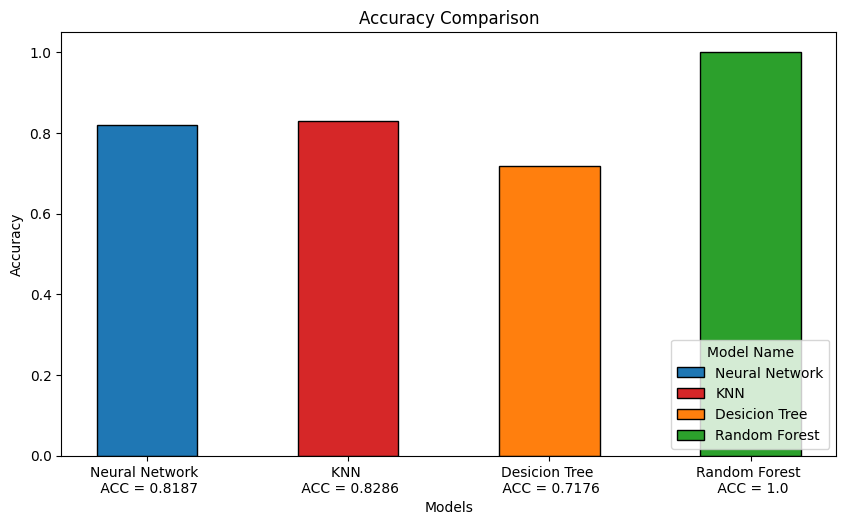

In [60]:
# เรียกใช้ function plot graph
# สร้างกราฟเปรียบเทียบค่า accuracy
plot_graph('Accuracy Comparison', 'Accuracy', acc_labels)

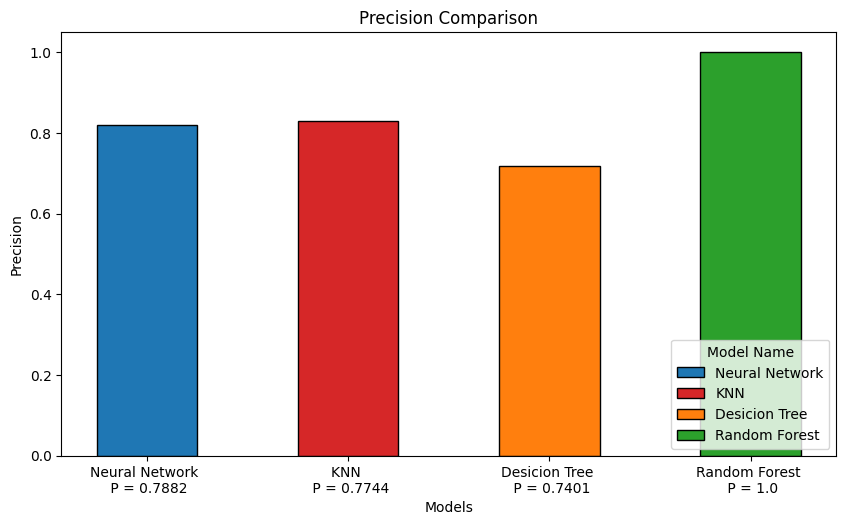

In [62]:
# สร้างกราฟเปรียบเทียบค่า precision
plot_graph('Precision Comparison', 'Precision', pre_labels)

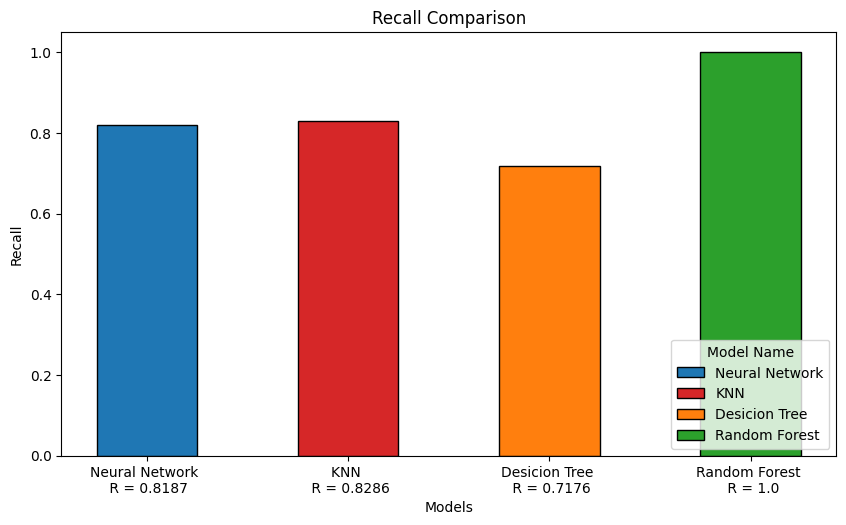

In [63]:
# สร้างกราฟเปรียบเทียบค่า recall
plot_graph('Recall Comparison', 'Recall', rec_labels)